## EDA

Изучим представленные данные

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('marketing_AB.csv')

In [ ]:
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


Пропусков в данных нет

In [ ]:
df['most ads day'].value_counts()

,count
most ads day,
Friday,92608
Monday,87073
Sunday,85391
Thursday,82982
Saturday,81660
Wednesday,80908
Tuesday,77479


In [ ]:
df['converted']

,converted
0,False
1,False
2,False
3,False
4,False
...,...
588096,False
588097,False
588098,False
588099,False


Видно, что часть данных относится к категориальным. Преобразуем в категориальный тип данных нужные признаки.

In [ ]:
df['test group'] = df['test group'].astype('category')
df['most ads day'] = df['most ads day'].astype('category')
df['converted'] = df['converted'].astype(int)
df['converted']

,converted
0,0
1,0
2,0
3,0
4,0
...,...
588096,0
588097,0
588098,0
588099,0


In [ ]:
df['user id'].value_counts()

,count
user id,
1237779,1
1069124,1
1119715,1
1144181,1
1435133,1
...,...
1446284,1
1448851,1
1496843,1


Видим, что unamed: 0 фактически ненужная индексная колонка, удалим ее, и проверим пропуски

In [ ]:
df.drop(columns=['Unnamed: 0'], inplace=True)
print(df.isnull().sum())

user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64


Пропусков нет

In [ ]:
print(df['test group'].unique())

['ad', 'psa']
Categories (2, object): ['ad', 'psa']


В тестовой группе пользователи разделены на тех, кто видел рекламу и не видел.
Сделаем 2 датасета и посмотрим, сколько в каждом пользователей.

In [ ]:
group_ad = df[df['test group'] == 'ad']
group_psa = df[df['test group'] == 'psa']

In [ ]:
print(f"Всего записей в данных: {len(df)}")

print("Распределение по группам:")
print(df['test group'].value_counts())

print(f"Уникальных пользователей: {df['user id'].nunique()}")
print(f"Дубликатов user id: {len(df) - df['user id'].nunique()}")

Всего записей в данных: 588101
Распределение по группам:
test group
ad     564577
psa     23524
Name: count, dtype: int64
Уникальных пользователей: 588101
Дубликатов user id: 0


Сделаем визуальную проверку на нормальность распределения

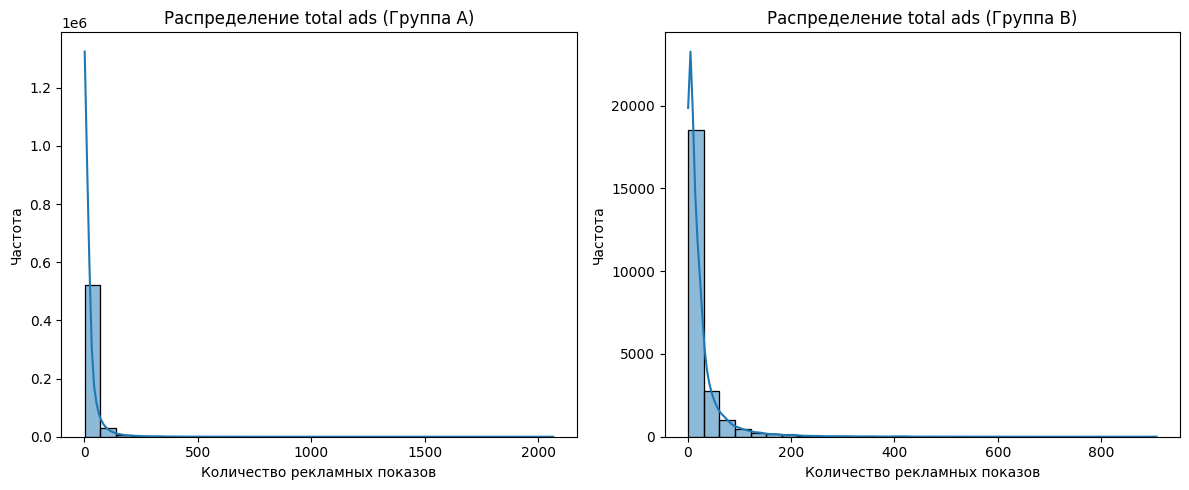

In [ ]:
plt.figure(figsize=(12, 5))

# Группа A (ad)
plt.subplot(1, 2, 1)
sns.histplot(group_ad['total ads'], bins=30, kde=True)
plt.title('Распределение total ads (Группа A)')
plt.xlabel('Количество рекламных показов')
plt.ylabel('Частота')

# Группа B (psa)
plt.subplot(1, 2, 2)
sns.histplot(group_psa['total ads'], bins=30, kde=True)
plt.title('Распределение total ads (Группа B)')
plt.xlabel('Количество рекламных показов')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

Визуальный анализ показывает, что распределение количества рекламных показов не соответствует нормальному распределению в обеих группах.
Кроме того, по совету ментора для бинарных метрик(converted), будем использовать z-тест для пропорций.

In [ ]:
from scipy.stats import shapiro, ks_2samp

shapiro_a = shapiro(group_ad['total ads'].sample(5000, random_state=42))
print(f"Тест Шапиро-Уилка для группы A: W = {shapiro_a[0]:.3f}, p-value = {shapiro_a[1]:.3e}")

shapiro_b = shapiro(group_psa['total ads'].sample(5000, random_state=42))
print(f"Тест Шапиро-Уилка для группы B: W = {shapiro_b[0]:.3f}, p-value = {shapiro_b[1]:.3e}")

ks_test = ks_2samp(group_ad['total ads'], group_psa['total ads'])
print(f"Тест Колмогорова-Смирнова: D = {ks_test[0]:.3f}, p-value = {ks_test[1]:.3e}")

Тест Шапиро-Уилка для группы A: W = 0.515, p-value = 1.640e-79
Тест Шапиро-Уилка для группы B: W = 0.521, p-value = 3.327e-79
Тест Колмогорова-Смирнова: D = 0.040, p-value = 2.343e-31


Крайне низкие p-values (практически 0) однозначно указывают на то, что распределение количества рекламных показов в обеих группах значимо отличается от нормального распределения.

## Формулировка гипотез
Нулевая гипотеза (H₀): Конверсия в группе A (реклама) равна конверсии в группе B (PSA).

Альтернативная гипотеза (H₁): Конверсия в группе A (реклама) не равна конверсии в группе B (PSA).

Найдем количество пользователей в обеих группах

In [ ]:
intersection_users = list(set(df[df['test group'] == 'ad']['user id'].values) & \
set(df[df['test group'] == 'psa']['user id'].values))
print('Кол-во пользователей, попавших в обе группы:', len(intersection_users))

Кол-во пользователей, попавших в обе группы: 0


Пересекающихся групп нет, все хорошо. Построим гистограммы времени на сайте группы а и б

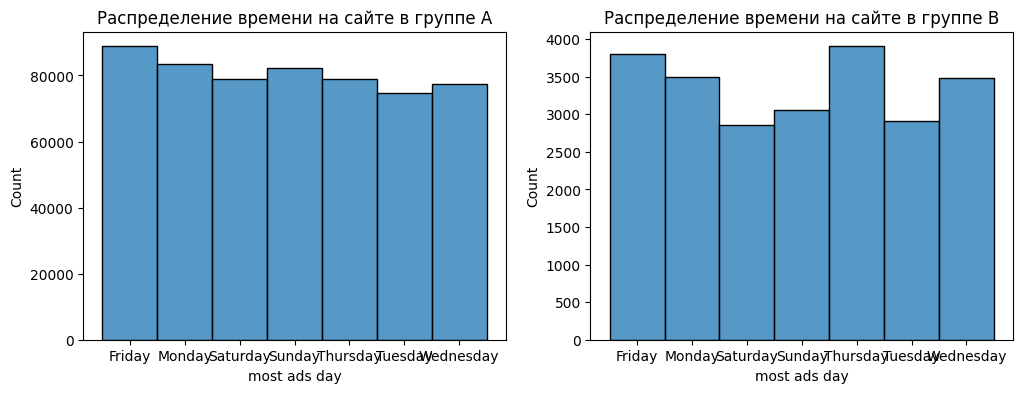

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(x='most ads day', data=group_ad, ax=axes[0])
sns.histplot(x='most ads day', data=group_psa, ax=axes[1])

axes[0].set_title('Распределение времени на сайте в группе А');
axes[1].set_title('Распределение времени на сайте в группе B');

Посчитаем конверсию

In [ ]:
grouped_data = df.groupby('test group').agg({'user id': 'count', 'converted': 'sum', 'total ads': 'sum'}).rename({'user id': 'count_of_visits', 'converted': 'count_of_purchases'}, axis=1)
grouped_data['conversion'] = grouped_data['count_of_purchases'] / grouped_data['count_of_visits'] * 100
grouped_data['mean ads'] = grouped_data['total ads'] / grouped_data['count_of_visits']
display(grouped_data)

<ipython-input-96-a3bdc118310f>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby('test group').agg({'user id': 'count', 'converted': 'sum', 'total ads': 'sum'}).rename({'user id': 'count_of_visits', 'converted': 'count_of_purchases'}, axis=1)


,count_of_visits,count_of_purchases,total ads,conversion,mean ads
test group,,,,,
ad,564577,14423,14014701,2.554656,24.823365
psa,23524,420,582481,1.785411,24.761138


<ipython-input-97-bf9aa5a59944>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=groups, y=conversion_rates, palette=['skyblue', 'salmon'], ax=ax1)
<ipython-input-97-bf9aa5a59944>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=groups, y=purchases, palette=['skyblue', 'salmon'], ax=ax2)
<ipython-input-97-bf9aa5a59944>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=groups, y=avg_ads, palette=['skyblue', 'salmon'], ax=ax3)


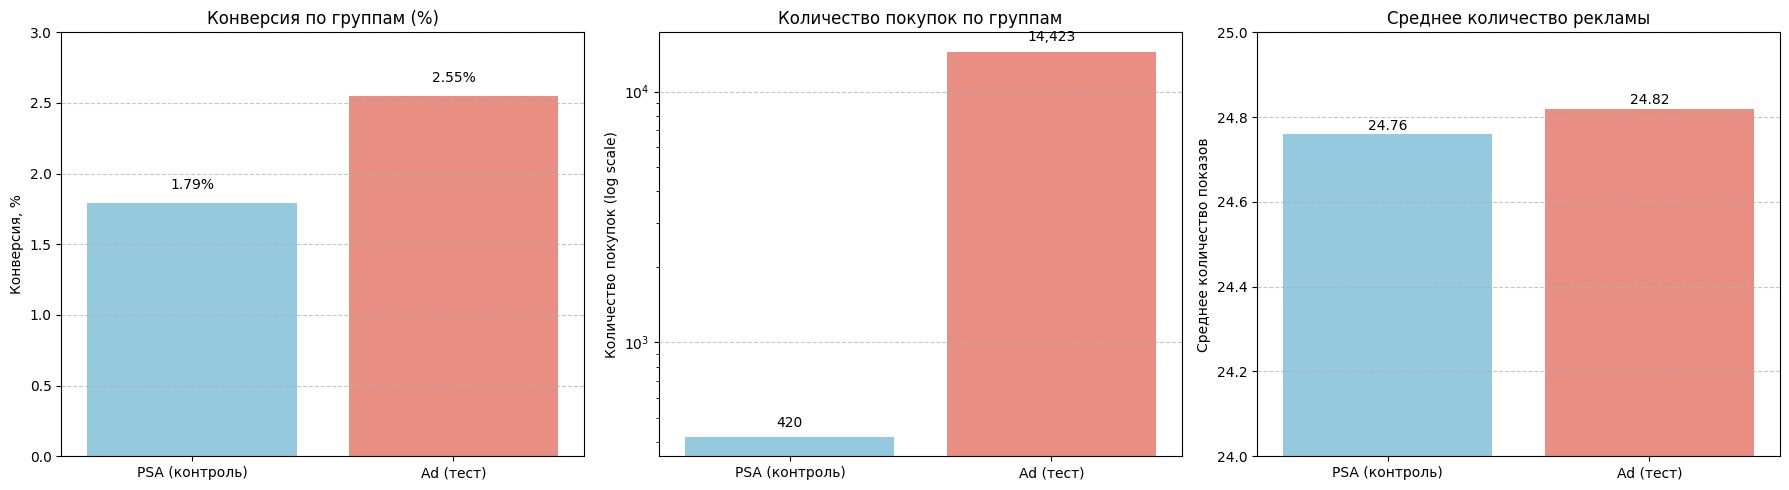

In [ ]:
groups = ['PSA (контроль)', 'Ad (тест)']
conversion_rates = [1.79, 2.55]  # в процентах
purchases = [420, 14423]  # абсолютные значения
avg_ads = [24.76, 24.82]  # среднее количество рекламы

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

sns.barplot(x=groups, y=conversion_rates, palette=['skyblue', 'salmon'], ax=ax1)
ax1.set_title('Конверсия по группам (%)')
ax1.set_ylabel('Конверсия, %')
ax1.set_ylim(0, 3)  # Фиксированный масштаб для сравнения
ax1.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(conversion_rates):
    ax1.text(i, v + 0.1, f"{v:.2f}%", ha='center')


sns.barplot(x=groups, y=purchases, palette=['skyblue', 'salmon'], ax=ax2)
ax2.set_title('Количество покупок по группам')
ax2.set_ylabel('Количество покупок (log scale)')
ax2.set_yscale('log')
ax2.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(purchases):
    ax2.text(i, v * 1.1, f"{v:,}", ha='center')

sns.barplot(x=groups, y=avg_ads, palette=['skyblue', 'salmon'], ax=ax3)
ax3.set_title('Среднее количество рекламы')
ax3.set_ylabel('Среднее количество показов')
ax3.set_ylim(24, 25)  # Узкий диапазон для подчеркивания различий
ax3.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(avg_ads):
    ax3.text(i, v + 0.01, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.show()

### Первичный анализ результатов

#### Ключевые метрики по группам:

| Показатель             | Группа A (ad) | Группа B (psa) |
|------------------------|---------------|----------------|
| Количество посещений    | 564,577       | 23,524         |
| Количество покупок      | 14,423        | 420            |
| Конверсия              | 2.55%         | 1.79%          |
| Среднее кол-во рекламы | 24.82         | 24.76          |

### Првичный вывод о результатах A/B-тестирования
На основе показателя конверсии и среднего количества увиденной рекламы в каждой из групп, можно заключить, что пользователи из группы А чаще совершают покупки, чем из группы B:  конверсия выше почти на 1% (2.55% vs 1.79%).
При этом, среднее количество увиденной рекламы примерно одинаковое, что подтверждает эффективность рекламной кампании.
Попробуем подтвердить это статистикой

## Проверка статистической значимости


In [ ]:
from statsmodels.stats.proportion import proportions_ztest

count = [14423, 420]  # Количество конверсий в группах
nobs = [564577, 23524]  # Общее количество наблюдений

z_stat, p_value = proportions_ztest(count, nobs)
print(f"Результат Z-теста:\nСтатистика = {z_stat:.3f}, p-value = {p_value:.5f}")

alpha = 0.05
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: различия статистически значимы")
else:
    print("Не отвергаем нулевую гипотезу: различия не статистически значимы")

Результат Z-теста:
Статистика = 7.370, p-value = 0.00000
Отвергаем нулевую гипотезу: различия статистически значимы


Группа A показала конверсию 2.55%, что значимо выше, чем 1.79% в группе B (p < 0.001). Однако по другим признакам различий не обнаружено. Можно рекомендовать внедрять изменения из группы А (рекламную кампанию)

In [ ]:
from scipy import stats

# T-тест для независимых выборок
t_stat, p_value = stats.ttest_ind(
    group_ad['total ads'],
    group_psa['total ads'],
    equal_var=False  # Используем Welch's t-test (разные дисперсии)
)

print(f"\nРезультат T-теста для среднего количества рекламы:")
print(f"Статистика = {t_stat:.3f}, p-value = {p_value:.5f}")

# Интерпретация
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: различия в среднем количестве рекламы значимы")
else:
    print("Не отвергаем нулевую гипотезу: различия не значимы")


Результат T-теста для среднего количества рекламы:
Статистика = 0.218, p-value = 0.82743
Не отвергаем нулевую гипотезу: различия не значимы


Это хороший результат, поскольку дизайн A/B-теста предполагает, что единственное различие между группами - это наличие/отсутствие рекламы.
Если бы количество показов рекламы значительно отличалось, это могло бы искажать результаты. Совпадение средних значений (24.82 vs 24.76) подтверждает корректность распределения пользователей

Посмотрим доверительные интервалы для конверсий

In [ ]:
from statsmodels.stats.proportion import proportion_confint

conversions = [14423, 420]
observations = [564577, 23524]

# 95% ДИ для конверсий
ci_ad = proportion_confint(conversions[0], observations[0], alpha=0.05, method='wilson')
ci_psa = proportion_confint(conversions[1], observations[1], alpha=0.05, method='wilson')

print("Доверительные интервалы для конверсий:")
print(f"Группа A (реклама): [{ci_ad[0]:.4f}, {ci_ad[1]:.4f}]")
print(f"Группа B (PSA):     [{ci_psa[0]:.4f}, {ci_psa[1]:.4f}]")

Доверительные интервалы для конверсий:
Группа A (реклама): [0.0251, 0.0260]
Группа B (PSA):     [0.0162, 0.0196]


In [ ]:
import math

p1 = conversions[0]/observations[0]
p2 = conversions[1]/observations[1]
diff = p1 - p2

# Стандартная ошибка разницы
se_diff = math.sqrt(p1*(1-p1)/observations[0] + p2*(1-p2)/observations[1])

# 95% ДИ для разницы
ci_diff = (diff - 1.96*se_diff, diff + 1.96*se_diff)

print(f"\nРазница конверсий (A-B): {diff:.4f}")
print(f"95% ДИ для разницы: [{ci_diff[0]:.4f}, {ci_diff[1]:.4f}]")


Разница конверсий (A-B): 0.0077
95% ДИ для разницы: [0.0060, 0.0094]


Посмотрим относительный прирост конверсии

In [ ]:
uplift = (grouped_data.loc['ad', 'conversion'] - grouped_data.loc['psa', 'conversion']) / grouped_data.loc['psa', 'conversion'] * 100
print(f"Относительный прирост: {uplift:.1f}%")

Относительный прирост: 43.1%


Относительный прирост конверсии = 43.1%. Для бизнеса это означает, что реклама увеличивает конверсию на 43% относительно базового уровня.



In [ ]:
from scipy.stats import t

# Данные по рекламе
mean_ad = 24.823365
mean_psa = 24.761138
std_ad = group_ad['total ads'].std()
std_psa = group_psa['total ads'].std()
n_ad = len(group_ad)
n_psa = len(group_psa)

# 95% ДИ для группы A
ci_ads_ad = (
    mean_ad - 1.96*std_ad/math.sqrt(n_ad),
    mean_ad + 1.96*std_ad/math.sqrt(n_ad)
)

# 95% ДИ для группы B
ci_ads_psa = (
    mean_psa - 1.96*std_psa/math.sqrt(n_psa),
    mean_psa + 1.96*std_psa/math.sqrt(n_psa)
)

print("\nДоверительные интервалы для среднего количества рекламы:")
print(f"Группа A: [{ci_ads_ad[0]:.2f}, {ci_ads_ad[1]:.2f}]")
print(f"Группа B: [{ci_ads_psa[0]:.2f}, {ci_ads_psa[1]:.2f}]")


Доверительные интервалы для среднего количества рекламы:
Группа A: [24.71, 24.94]
Группа B: [24.21, 25.31]


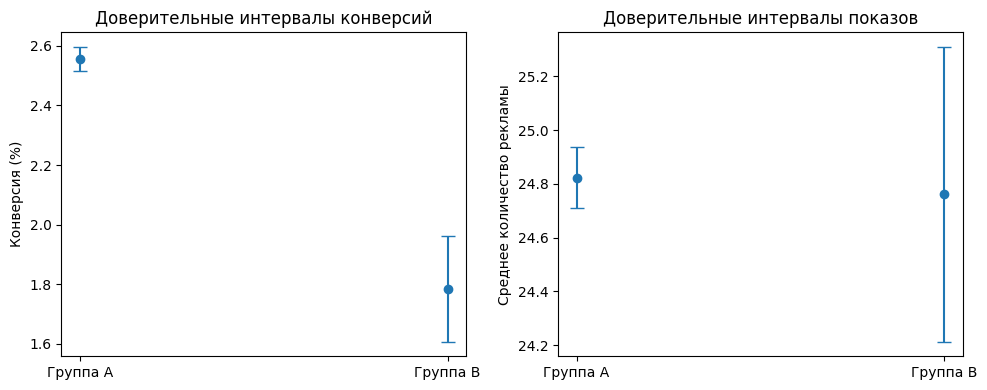

In [ ]:
plt.figure(figsize=(10, 4))

# Конверсии
plt.subplot(1, 2, 1)
plt.errorbar([0, 1], [p1*100, p2*100],
             yerr=[(p1-ci_ad[0])*100, (ci_psa[1]-p2)*100],
             fmt='o', capsize=5)
plt.xticks([0, 1], ['Группа A', 'Группа B'])
plt.ylabel('Конверсия (%)')
plt.title('Доверительные интервалы конверсий')

# Количество рекламы
plt.subplot(1, 2, 2)
plt.errorbar([0, 1], [mean_ad, mean_psa],
             yerr=[mean_ad-ci_ads_ad[0], ci_ads_psa[1]-mean_psa],
             fmt='o', capsize=5)
plt.xticks([0, 1], ['Группа A', 'Группа B'])
plt.ylabel('Среднее количество рекламы')
plt.title('Доверительные интервалы показов')

plt.tight_layout()
plt.show()

С 95% уверенностью можно утверждать, что истинная разница конверсий лежит в диапазоне от 0.60 до 0.94 процентных пункта
базового уровня

Доверительные интервалы показов рекламы значительно. Статистически значимых различий в среднем количестве показов между группами (p = 0.827)
Широкий интервал для группы B (PSA) связан с меньшим размером выборки (n=23,524 vs n=564,577 в группе A)

### Вывод
Рекламная кампания привела к статистически значимому увеличению конверсии на ~0.77 процентных пункта.
Разница хотя и небольшая в абсолютных значениях, но надежно детектируется. Отсутствие различий в количестве показов подтверждает, что эффект связан именно с рекламой, а не с другими факторами.

Отсутствие различий в количестве показов подтверждает корректность дизайна A/B-теста. Разница в конверсиях не может быть объяснена разной частотой демонстрации рекламных материалов.

Эффект рекламы можно считать доказанным, но его абсолютное значение невелико.